In [ ]:
!pip install kaggle
import os
import json
from zipfile import ZipFile
from PIL import Image
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sys
import os
from keras.applications.vgg16 import VGG16
import keras
from numpy import load
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense, Input
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import SGD
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dropout

In [ ]:
kaggle_credentails = json.load(open("kaggle.json"))

In [ ]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
new-plant-diseases-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

 drive	      'new plant diseases dataset(augmented)'   new-plant-diseases-dataset.zip	 test
 kaggle.json  'New Plant Diseases Dataset(Augmented)'   sample_data


In [ ]:
# Unzip the downloaded dataset
with ZipFile("new-plant-diseases-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
train_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
validation_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = '/content/test/test'

With that background in place, let’s look at how you can use pre-trained models to solve image and text problems. Whereas there are many steps involved in training a model, the focus will be on those six steps specific to transfer learning.

**Loading the dataset from a directory**

Let’s now load the images from their location. The `image_dataset_from_directory` function can be used because it can infer class labels.

The function will create a `tf.data.Dataset` from the directory.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=128,
                                             image_size=(256, 256))
valid_set = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=128,
                                                  image_size=(256, 256))

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [ ]:
"""
# Convert labels to one-hot encoded format
# Iterate through the dataset to extract labels
y_train = []
for images, labels in training_set:
    y_train.extend(labels.numpy())
y_train = tf.keras.utils.to_categorical(y_train, num_classes=38)

y_valid = []
for images, labels in valid_set:
    y_valid.extend(labels.numpy())
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=38)

# Extract image data into lists
x_train = []
for images, labels in training_set:
    x_train.extend(images.numpy())

x_valid = []
for images, labels in valid_set:
    x_valid.extend(images.numpy())

# Update the training and validation sets with one-hot encoded labels
training_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # Use x_train instead of training_set.data
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)) # Use x_valid instead of valid_set.data """

**Data pre-processing**

Whereas data pre-processing isn’t a specific step in transfer learning, it is an important step in training machine learning models in general. Let’s, therefore, apply some augmentation to the images. When you apply augmentation to a training set, you’re preventing overfitting, because augmentation exposes different aspects of the image to the model.

You especially want to augment the data when there’s not a lot of data for training. You can augment it using various transformations, like:



*   random rotations,
*   horizontal flipping,

*   zooming,
*   shearing.


You can apply these transformations when loading the data. Alternatively, as you can see below, you can augment by introducing unique layers.

In [ ]:
data_augmentation = keras.Sequential(
    [       keras.layers.RandomFlip("horizontal"),
   keras.layers.RandomRotation(0.1),
    ]
)

These layers will only be applied during the training process.

You can see the result of the above transformations by applying the layers to the same image. Here’s the code:

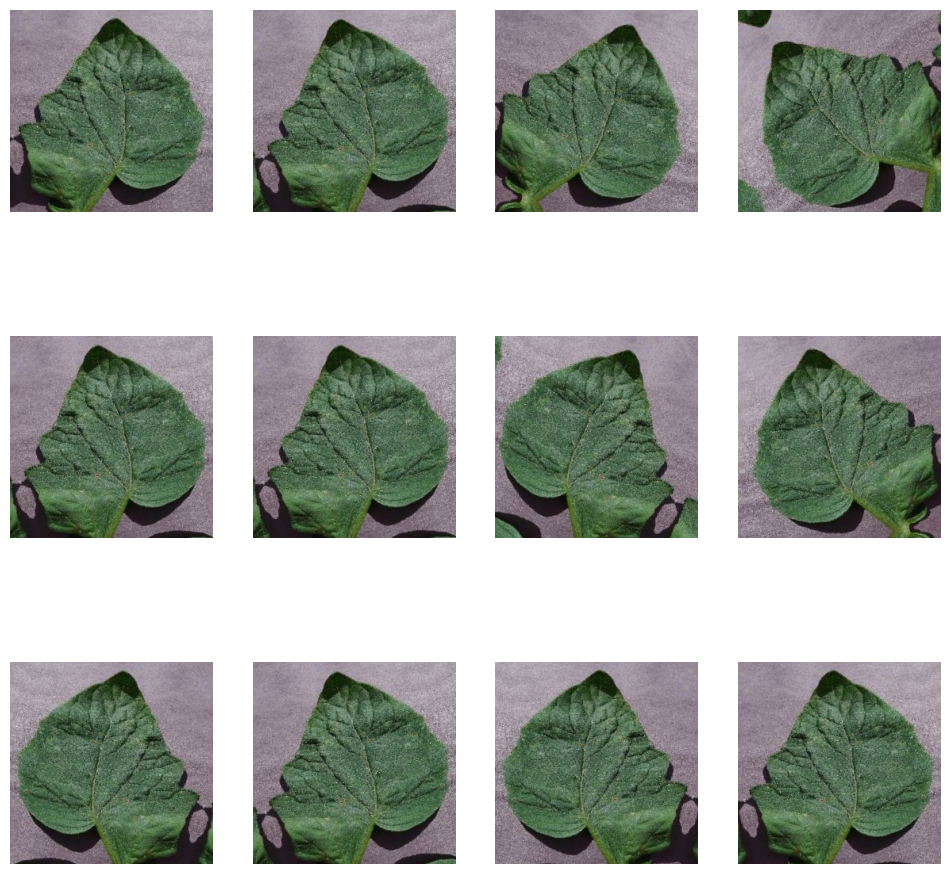

In [ ]:
for images, labels in training_set.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0)
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [ ]:
# Access the class indices from the DirectoryIterator object
class_names = training_set.class_names
class_dict = {class_name: i for i, class_name in enumerate(class_names)}
print(class_dict)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [ ]:
li = list(class_dict.keys())
print(li)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:
train_num = tf.data.experimental.cardinality(training_set).numpy()
valid_num = tf.data.experimental.cardinality(valid_set).numpy()

print(train_num)
print(valid_num)

550
138


**Create a base model from the pre-trained Xception model**

Let’s load the model with the weights trained on ImageNet. When that’s done, the desired input shape is defined.

`include_top=False` means that you’re not interested in the last layer of the model. Since models are visualized from bottom to top, that layer is referred to as the top layer. Excluding the top layers is important for feature extraction.



In [ ]:
# Set input shape for the base_model
IMG_SHAPE = (256, 256, 3)
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

Next, freeze the base model layers so that they’re not updated during the training process.

Since many pre-trained models have a `tf.keras.layers.BatchNormalization` layer, it’s important to freeze those layers. Otherwise, the layer mean and variance will be updated, which will destroy what the model has already learned. Let’s freeze all the layers in this case.

In [ ]:
base_model.trainable = False

**Create the final dense layer**

When loading the model, you used `include_top=False` meaning that the final dense layer of the pre-trained model wasn’t included. Now it’s time to define a final output layer for this model.

Let’s start by standardizing the size of the input images.

After this, apply the data augmentation.

This model expects data in the range of (-1,1) and not (0,1). So, you have to process the data.

Luckily, most pre-trained models provide a function for doing that.

Let’s now define the model as follows:


*   ensure that the base model is running in inference mode so that batch normalization layers are not updated during the fine-tuning stage (set `training=False`);

*   convert features from the base model to vectors, using `GlobalAveragePooling2D`;
*   apply dropout regularization;


*   add a final dense layer (when you used `include_top=False,` the final output layer was not included, so you have to define your own).


In [ ]:
model= Sequential()
model.add(Input(shape=(256, 256, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dense(38,activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 38)                  │       1,245,222 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,959,910 (60.88 MB)

 Trainable params: 1,245,222 (4.75 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Train the model**

You can now train the top layer. Notice that since you’re using a pretrained model, validation accuracy starts at an already high value.


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
batch_size = 32
history = model.fit(training_set,
                         steps_per_epoch=train_num//batch_size,
                         validation_data=valid_set,
                         epochs=20,
                         validation_steps=valid_num//batch_size,
                         )

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 67s 995ms/step - accuracy: 0.2794 - loss: 24.6533 - val_accuracy: 0.7305 - val_loss: 6.3842
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 947ms/step - accuracy: 0.7592 - loss: 6.0653 - val_accuracy: 0.8066 - val_loss: 4.4472
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 966ms/step - accuracy: 0.8330 - loss: 3.2495 - val_accuracy: 0.8457 - val_loss: 3.0547
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 933ms/step - accuracy: 0.8492 - loss: 3.2445 - val_accuracy: 0.8848 - val_loss: 2.1372
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 914ms/step - accuracy: 0.8684 - loss: 2.6513 - val_accuracy: 0.8828 - val_loss: 2.5025


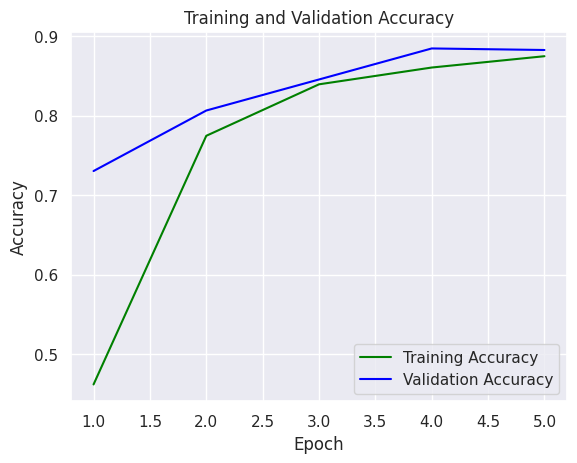

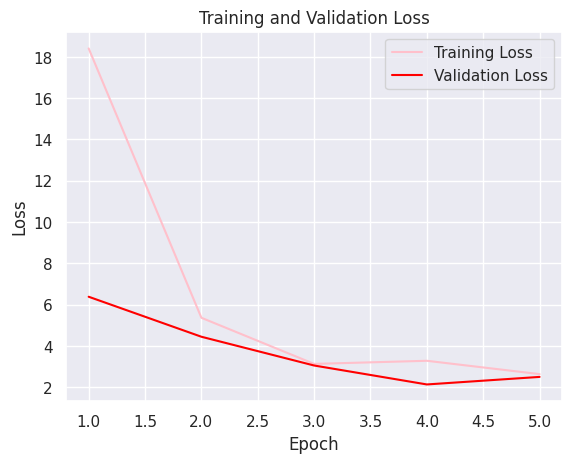

In [ ]:
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Fine-tuning the model**

The model can be improved by unfreezing the base model, and retraining it on a very low learning rate.

You need to monitor this step because the wrong implementation can lead to overfitting. First, unfreeze the base model.

In [ ]:
base_model.trainable = True

After updating the trainable attribute, the model has to be compiled again to implement the change.

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

To prevent overfitting, let’s monitor training loss via a callback. Keras will stop training when the model doesn’t improve for five consecutive epochs. Let’s also use TensorBoard to monitor loss and accuracy.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
!rm -rf logs
%load_ext tensorboard
log_folder = 'logs'
callbacks = [
            EarlyStopping(patience = 5),
            TensorBoard(log_dir=log_folder)
            ]

In [ ]:
batch_size = 32
history = model.fit(training_set,
                         steps_per_epoch=train_num//batch_size,
                         validation_data=valid_set,
                         epochs=20,
                         validation_steps=valid_num//batch_size,
                         callbacks=callbacks
                         )

In [ ]:
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# predicting an image
image_path = "/content/test/test/AppleCedarRust1.JPG"
new_img = image.load_img(image_path, target_size=(256, 256))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

At this point, you have a working model for the cats and dogs classification dataset.

If you were tracking this using an experimentation platform, you can now save the model and send it to your model registry.

In [ ]:
model.save("transfer_learning_model.h5")